In [1]:
# Add the necessary pythia build paths to the python paths
import sys
cfg = open("../software/pythia8312/Makefile.inc")  # Read necessary paths from this file
lib = "../software/lib"
for line in cfg:
    if line.startswith("PREFIX_LIB="): lib = line[11:-1]; break  # Find build paths
sys.path.insert(0, lib)   # Add build paths to system path

In [2]:
# Import Pythia8
import pythia8

# Import Tensor Libs
import numpy as np
import awkward as ak

# Import ML Libs
import torch
from torch.utils.data import Dataset, DataLoader

# Import Plotting Libs
import matplotlib.pyplot as plt

### Initialize Pythia with Signal and Background Processes

In [3]:
pythia_sig = pythia8.Pythia()                  # Define a pythia8.Pythia() object
pythia_sig.readString("Beams:eCM = 14000.")    # Beam energy is 14TeV
pythia_sig.readString("Beams:idA = 2212")      # Incoming particle 1 is proton
pythia_sig.readString("Beams:idB = 2212")      # Incoming particle 2 is proton
pythia_sig.readString("Top:qqbar2ttbar = on")  # Turn on all top processes
pythia_sig.init()                              # Initialize object with user defined settings


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.312      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 23 May 2024  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |   P       Y      T    H   H  III  A   A    Now is 30 Jun 2025 at 15:50:47    |  | 
 |  |                                                                              |  | 
 |  |   Program docu

True

                   |
 |------------------------------------------------------------------|
 |                                                    |             |
 | Subprocess                                    Code |   Estimated |
 |                                                    |    max (mb) |
 |                                                    |             |
 |------------------------------------------------------------------|
 |                                                    |             |
 | q qbar -> t tbar                               602 |   1.084e-06 |
 |                                                                  |
 *-------  End PYTHIA Process Initialization -----------------------*

 *-------  PYTHIA Multiparton Interactions Initialization  ---------* 
 |                                                                  | 
 |                   sigmaNonDiffractive =    57.17 mb              | 
 |                                                               

In [4]:
pythia_bkg = pythia8.Pythia()                  # Define a pythia8.Pythia() object
pythia_bkg.readString("Beams:eCM = 14000.")    # Beam enegery is 14TeV
pythia_bkg.readString("Beams:idA = 2212")      # Incoming particle 1 is proton
pythia_bkg.readString("Beams:idB = 2212")      # Incoming particle 2 is proton
pythia_bkg.readString("WeakDoubleBoson:ffbar2WW = on")      # Turn on all Diboson process
pythia_bkg.init()                              # Initialize object with user defined settings


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.312      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 23 May 2024  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |   P       Y      T    H   H  III  A   A    Now is 30 Jun 2025 at 15:50:47    |  | 
 |  |                                                                              |  | 
 |  |   Program docu

True

mentation and an archive of historic versions is found on:     |  | 
 |  |                                                                              |  | 
 |  |                               https://pythia.org/                            |  | 
 |  |                                                                              |  | 
 |  |   PYTHIA is authored by a collaboration consisting of:                       |  | 
 |  |                                                                              |  | 
 |  |   Javira Altmann, Christian Bierlich, Naomi Cooke, Nishita Desai,            |  | 
 |  |   Leif Gellersen, Ilkka Helenius, Philip Ilten, Leif Lonnblad,               |  | 
 |  |   Stephen Mrenna, Christian Preuss, Torbjorn Sjostrand, Peter Skands,        |  | 
 |  |   Marius Utheim, and Rob Verheyen.                                           |  | 
 |  |                                                                              |  | 
 |  |   The complete list of authors, inc

In [5]:
num_events = 1000

In [7]:
# Begin event loop. Generate event. Skip if error.
sig_events = []
for iEvent in range(num_events):           # Loop through events
    event_sig = []
    if iEvent%5==0:
        print("Generating Signal: ", iEvent, " / ", num_events, end="\r")
    if not pythia_sig.next(): continue     # Standard pythia syntax to trigger next event generation
    for prt in pythia_sig.event:           # Loop through particles in each event
        if prt.isFinal():                  # Check if particle is final state particle and store pT, eta, phi
            event_sig.append([prt.pT(),prt.eta(),prt.phi()])
    sig_events.append(event_sig)
print("Done Generating Signal: ", num_events, " / ", num_events)

print("Converting to Awkward Array...")
sig_events = ak.Array(sig_events)
print("Done Converting to Awkward Array")

Done Generating Signal:  1000  /  1000
Converting to Awkward Array...
Done Converting to Awkward Array


In [8]:
# Begin event loop. Generate event. Skip if error.
bkg_events = []
for iEvent in range(num_events):          # Loop through events
    event_bkg = []
    if iEvent%5==0:
        print("Generating Background: ", iEvent, " / ", num_events, end="\r")
    if not pythia_bkg.next(): continue    # Standard pythia syntax to trigger enxt event generation
    for prt in pythia_bkg.event:          # Loop through particles in each event
        if prt.isFinal():                 # Chekc if particle is final stat particle and store pT, eta, phi
            event_bkg.append([prt.pT(),prt.eta(),prt.phi()])
    bkg_events.append(event_bkg)
print("Done Generating Background: ", num_events, " / ", num_events)

print("Converting to Awkward Array...")
bkg_events = ak.Array(bkg_events)
print("Done Converting to Awkward Array")

Done Generating Background:  1000  /  1000
Converting to Awkward Array...
Done Converting to Awkward Array


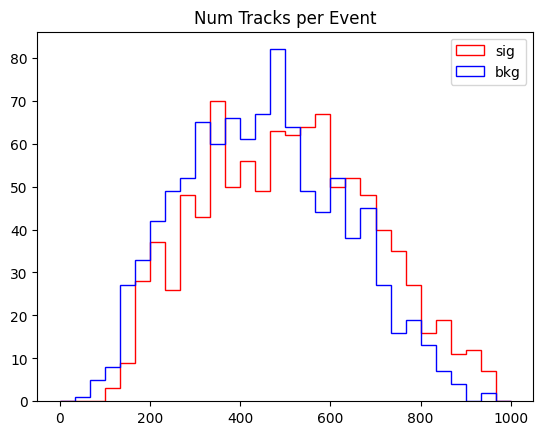

In [9]:
plt.title("Num Tracks per Event")
plt.hist(ak.num(sig_events),histtype='step',color='r',range=(0,1000),bins=30,label='sig')
plt.hist(ak.num(bkg_events),histtype='step',color='b',range=(0,1000),bins=30,label='bkg')
plt.legend()
plt.show()

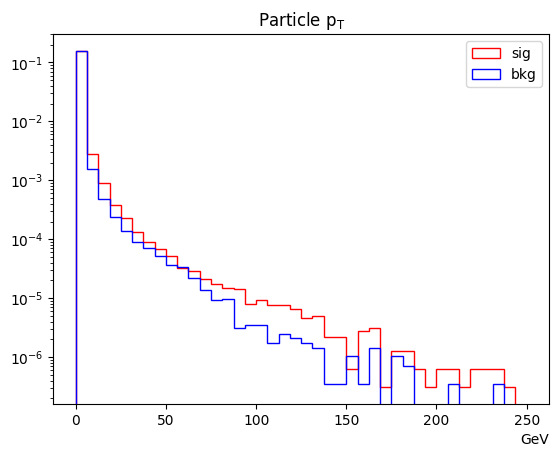

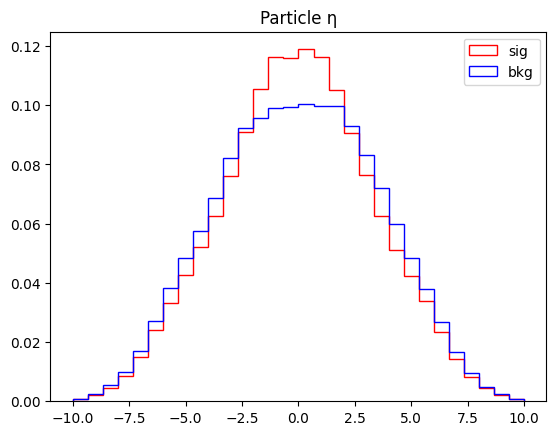

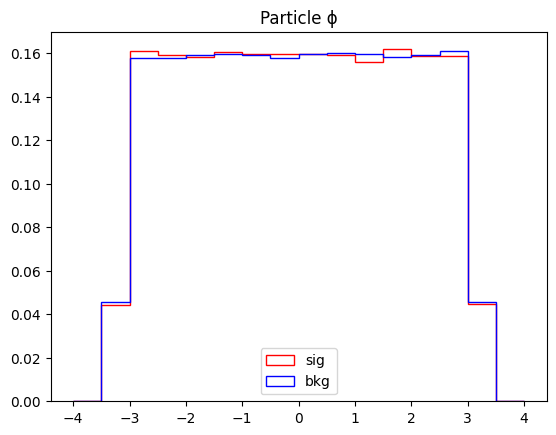

In [10]:
# Plot pT for signal and background
plt.title("Particle p$\mathregular{_{T}}$")
plt.hist(ak.ravel(sig_events[:,:,0]),bins=40,range=(0,250),histtype='step',label='sig',color='r',density=True)
plt.hist(ak.ravel(bkg_events[:,:,0]),bins=40,range=(0,250),histtype='step',label='bkg',color='b',density=True)
plt.xlabel('GeV',loc='right')
plt.yscale('log')
plt.legend()
plt.show()

# Plot eta for signal and background
plt.title("Particle \u03B7")
plt.hist(ak.ravel(sig_events[:,:,1]),bins=30,range=(-10,10),histtype='step',label='sig',color='r',density=True)
plt.hist(ak.ravel(bkg_events[:,:,1]),bins=30,range=(-10,10),histtype='step',label='bkg',color='b',density=True)
plt.legend()
plt.show()

# Plot phi for signal and background
plt.title("Particle \u03D5")
plt.hist(ak.ravel(sig_events[:,:,2]),bins=16,range=(-4,4),histtype='step',label='sig',color='r',density=True)
plt.hist(ak.ravel(bkg_events[:,:,2]),bins=16,range=(-4,4),histtype='step',label='bkg',color='b',density=True)
plt.legend()
plt.show()

In [11]:
sorted_args = ak.argsort(sig_events[:,:,0], ascending=False)
sorted_sig = sig_events[sorted_args]
sig_labels = np.ones((len(sorted_sig),1))

sorted_args = ak.argsort(bkg_events[:,:,0], ascending=False)
sorted_bkg = bkg_events[sorted_args]
bkg_labels = np.zeros((len(sorted_bkg),1))

combined_data = ak.concatenate([sorted_sig,sorted_bkg], axis=0)
combined_labels = ak.concatenate([sig_labels,bkg_labels], axis=0)

p = np.random.permutation(len(combined_data))
combined_data = combined_data[p]
combined_labels = combined_labels[p]

In [12]:
padding_particle_cutoff = 100

In [13]:
padded_data = []
for i, event in enumerate(combined_data):
    if i%5==0:
        print("Padding Dataset: ", i, " / ", len(combined_data), end="\r")
    event_data = []
    for j in range(padding_particle_cutoff):
        if j<len(event):
            event_data.append(event[j])
        else:
            event_data.append([0,0,0])
    padded_data.append(event_data)
print("Done Padding Dataset: ", len(combined_data), " / ", len(combined_data))

print("Converting to Awkward Array...")
padded_data = ak.Array(padded_data)
print("Done Converting to Awkward Array")

Done Padding Dataset:  2000  /  2000
Converting to Awkward Array...
Done Converting to Awkward Array


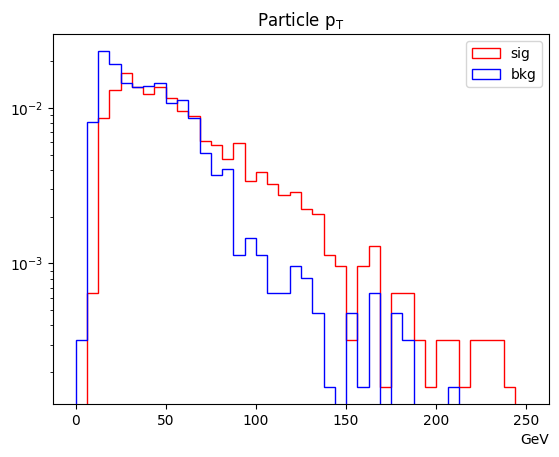

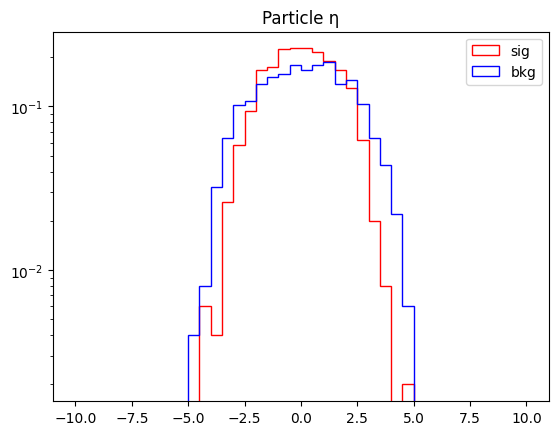

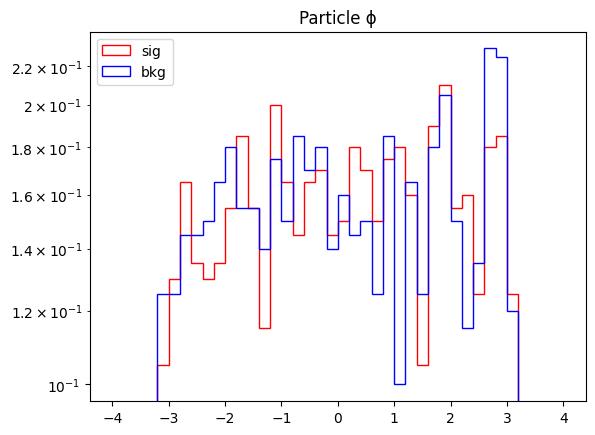

In [14]:
sig = combined_labels==1
bkg = combined_labels==0

# Plot pT for signal and background
plt.title("Particle p$\mathregular{_{T}}$")
plt.hist(ak.ravel(padded_data[sig][:,0]),bins=40,range=(0,250),histtype='step',label='sig',color='r',density=True)
plt.hist(ak.ravel(padded_data[bkg][:,0]),bins=40,range=(0,250),histtype='step',label='bkg',color='b',density=True)
plt.xlabel('GeV',loc='right')
plt.yscale('log')
plt.legend()
plt.show()

# Plot eta for signal and background
plt.title("Particle \u03B7")
plt.hist(ak.ravel(padded_data[sig][:,1]),bins=40,range=(-10,10),histtype='step',label='sig',color='r',density=True)
plt.hist(ak.ravel(padded_data[bkg][:,1]),bins=40,range=(-10,10),histtype='step',label='bkg',color='b',density=True)
plt.yscale('log')
plt.legend()
plt.show()

# Plot phi for signal and background
plt.title("Particle \u03D5")
plt.hist(ak.ravel(padded_data[sig][:,2]),bins=40,range=(-4,4),histtype='step',label='sig',color='r',density=True)
plt.hist(ak.ravel(padded_data[bkg][:,2]),bins=40,range=(-4,4),histtype='step',label='bkg',color='b',density=True)
plt.yscale('log')
plt.legend()
plt.show()

In [15]:
class ParticleDataset(Dataset):
    def __init__(self, data, labels, device):
        self.data = torch.tensor(data, dtype=torch.float32).to(device)
        self.labels = torch.tensor(labels, dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        event = self.data[idx]
        label = self.labels[idx]
        return event, label

In [16]:
train_split = int(0.7*len(padded_data))
test_split = int(0.75*len(padded_data))
device="cpu"

In [17]:
train_dataset = ParticleDataset(padded_data[0:train_split], combined_labels[0:train_split], device)
val_dataset = ParticleDataset(padded_data[train_split:test_split], combined_labels[train_split:test_split], device)
test_dataset = ParticleDataset(padded_data[test_split:], combined_labels[test_split:], device)

torch.save(train_dataset, "../datasets/train_dataset.pt")
torch.save(val_dataset, "../datasets/val_dataset.pt")
torch.save(test_dataset, "../datasets/test_dataset.pt")

In [18]:
train_dataloader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1024, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1024, shuffle=True)

In [19]:
for inputs, labels in train_dataloader:
    print("Batch shape:", inputs.shape)
    print("Labels shape:", labels.shape)
    break # only print the first batch

Batch shape: torch.Size([1024, 100, 3])
Labels shape: torch.Size([1024, 1])
